In [ ]:
!pip install transformers datasets scikit-learn pandas

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import TextClassificationPipeline


In [ ]:
# ✅ Veri Setini Yükle
df = pd.read_csv("temizlenmis_veri.csv")
df.head()


,label,label_num,text
0,spam,1,konu transfer yöneticisi i̇kincil ücretli i̇ş ...
1,spam,1,konu fwd i̇htiyaç duyduğunuz soffttwares önce ...
2,ham,0,konu noel ağacı çiftliği resimleri ram tackett...
3,spam,1,konu i̇htiyacınız olanı i̇nternette ucuz öncek...
4,ham,0,konu valero plants hey buddy gidiyor umuyorsun...


In [ ]:
# Sayısal etiketler varsa, bunları metne çevirerek göster
etiket_ismi = {0: "Ham", 1: "Spam"}
df['etiket_metni'] = df['label_num'].map(etiket_ismi)

print(df['etiket_metni'].value_counts())


etiket_metni
Ham     15966
Spam    15603
Name: count, dtype: int64


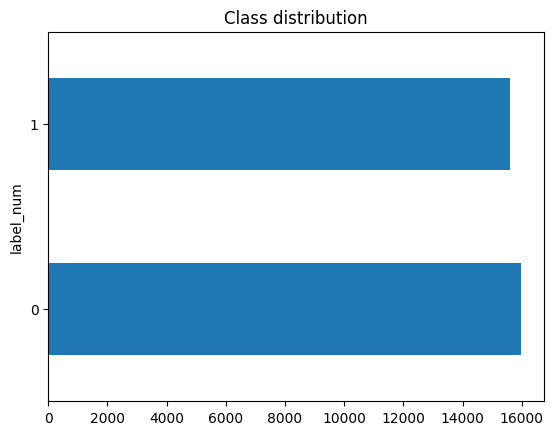

In [ ]:
# ✅ Etiketlerin Dağılımını Göster
df['label'].value_counts()
df["label_num"].value_counts(ascending=False).plot.barh()
plt.title("Class distribution")
plt.show()

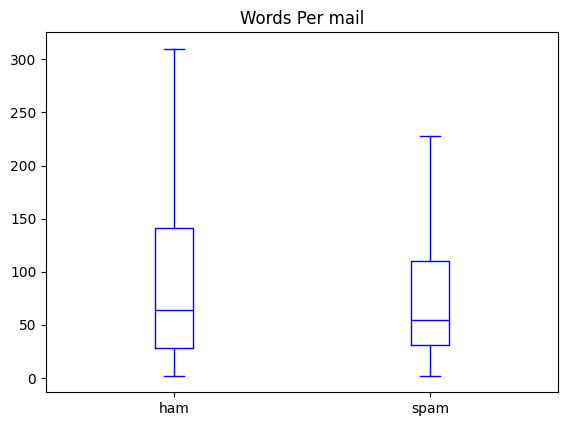

In [ ]:
df["Words Per mail"] = df["text"].str.split().apply(len)
df.boxplot("Words Per mail", by="label", grid=False, showfliers=False, color="blue")
plt.suptitle("")
plt.xlabel("")
plt.show()



In [ ]:
# ✅ Eğitim ve Doğrulama Verilerini Ayır
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text"], df["label_num"], test_size=0.1, random_state=42
)


In [ ]:
# ✅ Tokenizer ve veri dönüştürme
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True)

train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'label': list(train_labels)
})
val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'label': list(val_labels)
})


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [ ]:
# ✅ Model ve eğitim ayarları
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="none",
)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# ✅ Eğitim
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()


<ipython-input-12-51a190fedb51>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.357400
1000,0.179700
1500,0.142800
2000,0.118800
2500,0.102700
3000,0.085800
3500,0.102300
4000,0.036100
4500,0.039300
5000,0.056200


TrainOutput(global_step=10656, training_loss=0.06845465657236921, metrics={'train_runtime': 2008.8222, 'train_samples_per_second': 42.431, 'train_steps_per_second': 5.305, 'total_flos': 2.242653391466496e+16, 'train_loss': 0.06845465657236921, 'epoch': 3.0})

In [ ]:


# ✅ Pipeline tanımla
spam_tespiti = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False)

# ✅ Örnek metinler
ornek1 = "Tebrikler! Bedava iPhone kazandınız. Hemen tıklayın!"
ornek2 = "Toplantı saat 15:00’te başlayacak. Katılım önemli."

# ✅ Tahminleri yazdır
print("1. Metin:", ornek1)
print("Tahmin:", spam_tespiti(ornek1), "\n")

print("2. Metin:", ornek2)
print("Tahmin:", spam_tespiti(ornek2))


Device set to use cuda:0


1. Metin: Tebrikler! Bedava iPhone kazandınız. Hemen tıklayın!
Tahmin: [{'label': 'LABEL_1', 'score': 0.9999656677246094}] 

2. Metin: Toplantı saat 15:00’te başlayacak. Katılım önemli.
Tahmin: [{'label': 'LABEL_0', 'score': 0.9999668598175049}]


In [ ]:
# ✅ Modeli Kaydet
model.save_pretrained("bert-spam-model")
tokenizer.save_pretrained("bert-spam-model")


('bert-spam-model/tokenizer_config.json',
 'bert-spam-model/special_tokens_map.json',
 'bert-spam-model/vocab.txt',
 'bert-spam-model/added_tokens.json',
 'bert-spam-model/tokenizer.json')

In [ ]:
import shutil
shutil.make_archive("bert-spam-model", 'zip', "bert-spam-model")


'/content/bert-spam-model.zip'

In [ ]:
from google.colab import files
files.download("bert-spam-model.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from transformers import TextClassificationPipeline, AutoTokenizer # Import AutoTokenizer

# Get the max sequence length from the tokenizer
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
max_len = tokenizer.model_max_length # Get the model's max sequence length

# Etiketleri hazırla
y_true = val_labels.reset_index(drop=True).tolist()
y_pred = []

# Pipeline oluştur (truncation eklenmiş hali)
# pipeline yerine test_pipeline kullanın
test_pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False, max_length=max_len, truncation=True)


# Tahminleri al
for text in val_texts.reset_index(drop=True).astype(str):
    prediction = test_pipeline(text)[0]['label']
    y_pred.append(int(prediction.replace("LABEL_", "")))  # LABEL_0 → 0, LABEL_1 → 1

# Değerleri yazdır
print("✅ Accuracy (Doğruluk):", round(accuracy_score(y_true, y_pred), 4))
print("✅ Precision (Kesinlik):", round(precision_score(y_true, y_pred), 4))
print("✅ Recall (Duyarlılık):", round(recall_score(y_true, y_pred), 4))
print("✅ F1 Score:", round(f1_score(y_true, y_pred), 4))

# Detaylı rapor
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Ham", "Spam"]))

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


✅ Accuracy (Doğruluk): 0.9911
✅ Precision (Kesinlik): 0.9896
✅ Recall (Duyarlılık): 0.9922
✅ F1 Score: 0.9909

📊 Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99      1622
        Spam       0.99      0.99      0.99      1535

    accuracy                           0.99      3157
   macro avg       0.99      0.99      0.99      3157
weighted avg       0.99      0.99      0.99      3157

